# Change Point Detection in Time Series Sensor data

# 1 Environment Setup

## 1.1 Install dependent libraries

In [1]:
# Clear all objects from memory
 rm(list=ls())

# Check for installed libraries
 inspkgs = as.data.frame(installed.packages()[,c(1,3:4)])
 inspkgs = inspkgs[is.na(inspkgs$Priority),1:2,drop=FALSE]
 inspkgs[1:3,] # Displying only 3 sample packages


# Run the below commands for libraries installation only 
#    if they are not istalled already as indicated by the above command
#    Uncomment and run the installation commands below

# install.packages("sqldf")
# install.packages("ggplot2")
# install.packages("jsonlite", repos="http://cran.r-project.org")


,Package,Version
acepack,acepack,1.4.1
arules,arules,1.5-5
assertthat,assertthat,0.2.0


## 1.2 Load dependent libraries

In [2]:
library(sqldf)
library(httr)
library(RCurl)
library(bitops)
library(jsonlite)
library("aws.s3")
library(stringr)


Loading required package: gsubfn
Loading required package: proto
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“unable to load shared object '/opt/conda/envs/R/lib/R/modules//R_X11.so':
  libXt.so.6: cannot open shared object file: No such file or directory”Warning message:
“no DISPLAY variable so Tk is not available”Loading required package: RSQLite
Loading required package: bitops


# 2 Configure Parameters for Change Point Detection

## 2.1 Read DSX Configuration file and load all parameters

Complete below 2 steps before executing the rest of the cells
1. Configure the parameters in JSON file and upload to Object storage
2. Set the Configuration .json file name in the next section


### 2.1.1 Set the name of the .json configuration file

In [3]:
# Specify file names for sample text and configuration files
# Not required when reading data from database
v_sampleConfigFileName = "cpd_dsx_config.json"


### 2.1.2 Insert the Object Storage file credentials to read the .json configuration file

In [4]:
# @hidden_cell
# The section below needs to be modified:
#    Insert your credentials to read data from your data sources and replace 
#    the credentials.1 <- list() section below
credentials.1 <-list(
    endpoint = "https://s3-api.us-geo.objectstorage.service.networklayer.com",
    api.key = "bT_623i_H_rIyjvo-DYiU59M-YQvB9hyaaIc-QS3Bu9m",
    iam.service.id = "iam-ServiceId-bef1701c-ab8e-445f-8e68-af5da024ee91",
    bucket.name = "iotchangepointcloudstorage-donotdelete-pr-fqyloftlgsbqoc",
    file.name = "cpd_dsx_config.txt",
    access.key = "ca6e393e8bbf42db9bb29bcbe9ccffd7",
    secret.key = "8b691c9f809ecc79624c5a0363898085071ef342f3bc3977",
    iam.service.endpoint = "https://iam.ng.bluemix.net/oidc/token")


In [5]:
# This function accesses a file in your Object Storage. The definition contains your credentials.
url1 <- str_replace(credentials.1$endpoint, "https://", "")
url1 <- str_replace(url1, "http://", "")

obj <- s3HTTP(
    verb = "GET",
    bucket = credentials.1$bucket.name,
    path = v_sampleConfigFileName,
    key = credentials.1$access.key,
    secret = credentials.1$secret.key,
    check_region = FALSE,
    base_url =url1)


# Your data file was loaded into a textConnection object and you can process the data with your package of choice.
configtxt = textConnection(rawToChar(obj$content))


A connection with                                    
description "rawToChar(obj$content)"
class       "textConnection"        
mode        "r"                     
text        "text"                  
opened      "opened"                
can read    "yes"                   
can write   "no"                    

### 2.1.3 Read Configuration parametric values

In [6]:
# Function to Read json parametric values
f_getconfigval <- function(injsonstr, invarname)
{   # paramname, paramvalue
    injsonstr$paramvalue[injsonstr$paramname==invarname]
}


In [7]:
# Read json configuration file
# Please read the documentation of 'jsonlite' to learn more about the possibilities 
# to adjust the data loading.
# jsonlite documentation: https://cran.r-project.org/web/packages/jsonlite/jsonlite.pdf
jsonstr <-  fromJSON(readLines(configtxt))

head(jsonstr)

paramname,paramvalue
coltimestamp,TIMESTAMP
colsensorid,SENSORID
colsensorvalue,SENSORVALUE
sensorid,3B1
datatimeformat,%d-%m-%Y %H:%M:%S
intimezone,GMT


In [8]:
# Read json configuration parametric values
# 
# Name of the column which holds the Time stamp of data 
# recorded by Sensor
v_coltimestamp <- f_getconfigval(jsonstr, "coltimestamp")
# Name of the column which holds the Sensor identification
v_colsensorid <- f_getconfigval(jsonstr, "colsensorid")
# Name of the column that stores the values measured by sensor
v_colsensorvalue <- f_getconfigval(jsonstr, "colsensorvalue")
# Sensor ID for which the analysis needs to be applied
v_sensorid <- f_getconfigval(jsonstr, "sensorid")
# Time format of the data in the data frame
v_datatimeformat <- f_getconfigval(jsonstr, "datatimeformat")
# Time zone for the Time stamps
v_intimezone <- f_getconfigval(jsonstr, "intimezone")
# Time format which is used for specifying the
# time ranges in the below paraneters
v_rangetimeformat <- f_getconfigval(jsonstr, "rangetimeformat")
# Start Time for first series Time range
v_Pfrom <- f_getconfigval(jsonstr, "Pfrom")
# End Time for first series Time range
v_Pto <- f_getconfigval(jsonstr, "Pto")
# Start Time for second series Time range
v_Cfrom <- f_getconfigval(jsonstr, "Cfrom")
# End Time for second series Time range
v_Cto <- f_getconfigval(jsonstr, "Cto")
# Set the threshold percentage of change if detected
v_thresholdpercent <- as.numeric(f_getconfigval(jsonstr, "thresholdpercent"))


In [9]:
# Cross verify configuration parametric values
print(c(v_coltimestamp, v_colsensorid, v_colsensorvalue, v_sensorid,
        v_datatimeformat, v_intimezone, v_rangetimeformat, v_Pfrom,
        v_Pto, v_Cfrom, v_Cto, v_thresholdpercent))


 [1] "TIMESTAMP"         "SENSORID"          "SENSORVALUE"      
 [4] "3B1"               "%d-%m-%Y %H:%M:%S" "GMT"              
 [7] "%Y%m%d %H:%M:%S"   "20160324 00:00:00" "20160325 00:00:00"
[10] "20160325 00:00:00" "20160326 00:00:00" "25"               


# 3 Read IoT Sensor data from database

In [10]:
# Read data from DB2 Warehouse in BMX
library(ibmdbR)
library(RODBC)
library(Matrix)

# Call function to read data for specific sensor
# @hidden_cell
# The section below needs to be modified:
#    Insert your credentials to read data from your data sources and replace 
#    the idaConnect() section below
# This connection object is used to access your data and contains your credentials.

con_cpd <- idaConnect("DASHDB;DATABASE=BLUDB;HOSTNAME=dashdb-entry-yp-dal09-09.services.dal.bluemix.net;PORT=50000;PROTOCOL=TCPIP;",
                      uid = "dash10720", pwd = "32uf_R_giSXX", conType = "odbc")
idaInit(con_cpd)

alarmdf <- ida.data.frame('DASH10720.CHANGEPOINTIOT')


head(alarmdf)
nrow(alarmdf)


# You can close the connection with the following code:
# idaClose(con_cpd)



Loading required package: RODBC
Loading required package: Matrix
Loading required package: arules

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write



SENSORID,TIMESTAMP,SENSORVALUE,SENSORUNITS
3B1,24-03-2016 00:00:00,9.22500,FAHRENHEIT
3B1,24-03-2016 00:10:00,8.61000,FAHRENHEIT
3B1,24-03-2016 00:50:00,8.61000,FAHRENHEIT
3B1,24-03-2016 01:00:00,8.61000,FAHRENHEIT
3B1,24-03-2016 01:10:00,8.61000,FAHRENHEIT
3B1,24-03-2016 01:20:00,8.61000,FAHRENHEIT


[1] 432

In [11]:
# Function to translate from one datetime format to another datetime format
# Returns character strings in the converted format NOT in posix or datetime format <br/>
# DateTime passed in also should be in character string format

dtformatconvert <- function(indatetimes, fromdatetimeformat="%Y-%m-%d %H:%M:%S %p", 
                            todatetimeformat="%d-%m-%Y %H:%M:%S",
                            fromtz="GMT", totz="", usetz=FALSE)
    {
        return(strftime(as.POSIXct(indatetimes, format=fromdatetimeformat, tz=fromtz, usetz=FALSE), 
                            format=todatetimeformat, tz=totz, usetz=FALSE))
    }


## 3.1 Read data for 1 sensor for analysis
You can investigate the set of unique sensor ids in the data using the below command <br/>
[unique(alarmdf$SensorID)]

In [12]:
# Function to Standardise the Dataset with standard column names
# <Timestamp, SensorID, SensorValue>
f_readsensordata <- function(sensordf, sensorid, coltimestamp, colsensorid, colsensorval)
{
  # sensordf <- read.csv(paste(dirname, filename, sep=""), sep=",", as.is=TRUE, header=TRUE) ##as.is=TRUE to ensure Timestamp read in as character type
  sensordf1 <- sensordf[,c(coltimestamp, colsensorid, colsensorval)]
  sensordf1 <- as.data.frame(sensordf1)
  names(sensordf1) <- c("TimeStamp","SensorID","SensorValue")
  if (sensorid != "ALL")
  {
    sensordf1 <- sensordf1[sensordf1$SensorID==sensorid,]
  }
  #View(alarmdf1)
  rm(sensordf)
  return(sensordf1)
}


In [13]:
# Read data and store in R data frame
alarmdf <- f_readsensordata(sensordf = alarmdf, 
                            sensorid = v_sensorid, 
                            coltimestamp = v_coltimestamp, colsensorid=v_colsensorid, 
                            colsensorval=v_colsensorvalue)

alarmdf$SensorValue <- as.numeric(alarmdf$SensorValue)
head(alarmdf)

TimeStamp,SensorID,SensorValue
24-03-2016 00:00:00,3B1,9.225
24-03-2016 00:10:00,3B1,8.610
24-03-2016 00:50:00,3B1,8.610
24-03-2016 01:00:00,3B1,8.610
24-03-2016 01:10:00,3B1,8.610
24-03-2016 01:20:00,3B1,8.610


# 4 Prepare data

## 4.1 Sort the data by Time stamp in ascending order

In [14]:
# Sort the data by Time stamp
alarmdf <- alarmdf[with(alarmdf, 
                        order(SensorID, 
                              as.POSIXct(TimeStamp,format=v_datatimeformat, tz=v_intimezone))), ];

head(alarmdf)


,TimeStamp,SensorID,SensorValue
1,24-03-2016 00:00:00,3B1,9.225
2,24-03-2016 00:10:00,3B1,8.610
10,24-03-2016 00:20:00,3B1,8.610
39,24-03-2016 00:30:00,3B1,8.610
135,24-03-2016 00:40:00,3B1,8.610
3,24-03-2016 00:50:00,3B1,8.610


## 4.2 Split data into 2 divergent sets for detecting changes

In [15]:
# Function to split data into 2 datasets: Previous, Current
# IN: Standard Data Frame, SensorID,
#     Previous From Time stamp, Previous To Time stamp, 
#     Current From Time Stamp, Current To Time Stamp
# OUT: Data series <br/>
#     series 1 (SensorID, TimeStamp, SensorValue),
#     series 2 (SensorID, TimeStamp, SensorValue)

f_splitdataseries <- function(SensorID, Intimeformat, Datatimeformat, PFrom, PTo, CFrom, CTo)
{
  PFromPOSIX = as.POSIXct(PFrom, format=Intimeformat, tz="GMT", usetz=FALSE);
  PToPOSIX = as.POSIXct(PTo, format=Intimeformat, tz="GMT", usetz=FALSE);
  CFromPOSIX = as.POSIXct(CFrom, format=Intimeformat, tz="GMT", usetz=FALSE);
  CToPOSIX = as.POSIXct(CTo, format=Intimeformat, tz="GMT", usetz=FALSE);
  
  alarmdf$TimeStampPOSIX <- as.POSIXct(alarmdf$TimeStamp, 
                          format=Datatimeformat, tz="GMT", usetz=FALSE);

  series1 = alarmdf[which(alarmdf$SensorID ==SensorID & 
                          alarmdf$TimeStampPOSIX >= PFromPOSIX & alarmdf$TimeStampPOSIX < PToPOSIX),];
  series2 = alarmdf[which(alarmdf$SensorID ==SensorID & 
                          alarmdf$TimeStampPOSIX >= CFromPOSIX & alarmdf$TimeStampPOSIX < CToPOSIX),];
  return(list(series1, series2));
}


### Get the 2 Data series to compare

In [16]:
# Get the 2 Data series to compare (sample values shown for help)
#  s = f_splitdataseries (SensorID="3B1",
#                       Intimeformat="%Y%m%d %H:%M:%S", Datatimeformat="%d-%m-%Y %H:%M:%S",
#                       PFrom="20160324 00:00:00", PTo="20160325 00:00:00",
#                       CFrom="20160325 00:00:00", CTo="20160326 00:00:00")

s = f_splitdataseries (SensorID=v_sensorid,
                       Intimeformat=v_rangetimeformat, Datatimeformat=v_datatimeformat,
                       PFrom=v_Pfrom, PTo=v_Pto,
                       CFrom=v_Cfrom, CTo=v_Cto)


# Unpack the 2 list of data frames
series1 <- s[[1]]
series2 <- s[[2]]

head(series1)
head(series2)

,TimeStamp,SensorID,SensorValue,TimeStampPOSIX
1,24-03-2016 00:00:00,3B1,9.225,2016-03-24 00:00:00
2,24-03-2016 00:10:00,3B1,8.610,2016-03-24 00:10:00
10,24-03-2016 00:20:00,3B1,8.610,2016-03-24 00:20:00
39,24-03-2016 00:30:00,3B1,8.610,2016-03-24 00:30:00
135,24-03-2016 00:40:00,3B1,8.610,2016-03-24 00:40:00
3,24-03-2016 00:50:00,3B1,8.610,2016-03-24 00:50:00


,TimeStamp,SensorID,SensorValue,TimeStampPOSIX
151,25-03-2016 00:00:00,3B1,18.450,2016-03-25 00:00:00
142,25-03-2016 00:10:00,3B1,13.530,2016-03-25 00:10:00
143,25-03-2016 00:20:00,3B1,12.300,2016-03-25 00:20:00
144,25-03-2016 00:30:00,3B1,11.685,2016-03-25 00:30:00
145,25-03-2016 00:40:00,3B1,11.685,2016-03-25 00:40:00
146,25-03-2016 00:50:00,3B1,16.605,2016-03-25 00:50:00


# 5 Analyze the Data

## 5.1 Plot the line graphs for both the series <br/>

In [17]:
# Function to plot the line graphs for both the series
# IN parameters: (x,y values for both the Time series in sorted order) x1, y1, x2, y2
f_plot2lines <- function(x1, y1, x2, y2)
{
  # Draw Line plot
  # dev.new()
  plot(y1,type="l",col="green",xlab=" ", ylab=" ",pch=21,xaxt="n",yaxt="n")
  par(new=T)
  plot(y2,type="l",col="red",xlab="Time", ylab="Sensor Values",pch=21,xaxt="n",yaxt="n")
  axis(2,las=3,cex.axis=0.8)
  axis(1,at=c(1:length(x1)),c(x1),las=2,cex.axis=0.4)
  title("Sensor readings by Time overlay")
  par(new=F)
}


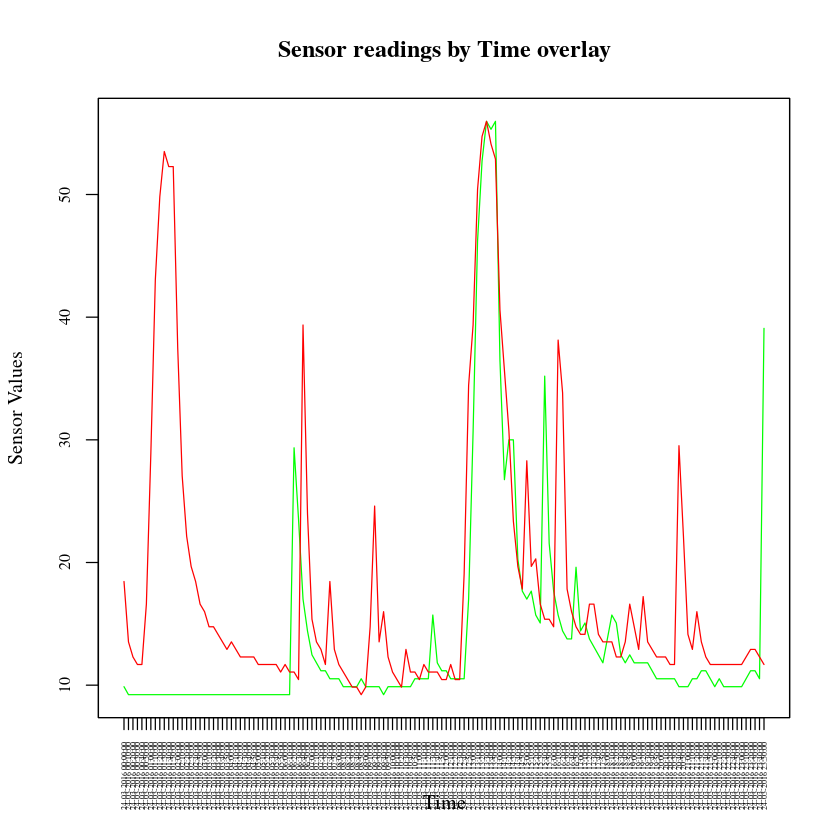

In [18]:
# Line plot of the 2 Data series
f_plot2lines(x1 <- series1$TimeStamp, y1 <- series1$SensorValue,
             x2 <- series2$TimeStamp, y2 <- series2$SensorValue)


## 5.2 Plot the box plots for both the distributions <br/>

In [19]:
# Function to plot the box plots for both the distributions <br/>
# Time series order does not matter for this <br/>
#     IN parameters: (Sensorvalues-series 1, Sensorvalues-series 2)
    
f_plot2boxes <- function(s1sensorvalue, s2sensorvalue)
{
  data_list = NULL
  col_list = c("green", "blue")
  names_list = c("Previous", "Current")
  
  data_list = list()
  data_list[[1]] = s1sensorvalue
  data_list[[2]] = s2sensorvalue
  
  # dev.new() # Works in PC only
  boxstats <- boxplot.stats(data_list[[1]], coef=1.57, do.conf = TRUE, do.out = TRUE)
  #par(new=T)
  boxplot(data_list, las = 2, col = col_list, ylim=c(-2.0,70),
          names= names_list,
          mar = c(12, 5, 4, 2) + 0.1,
          main="Change point detection",
          sub=paste("Spread of Sensor reading distributions", ":", sep=""),
          ylab="Sensor Readings", 
          coef=1.57, do.conf = TRUE, do.out = TRUE)
  abline(h=boxstats$stats, col="green", las=2)
}


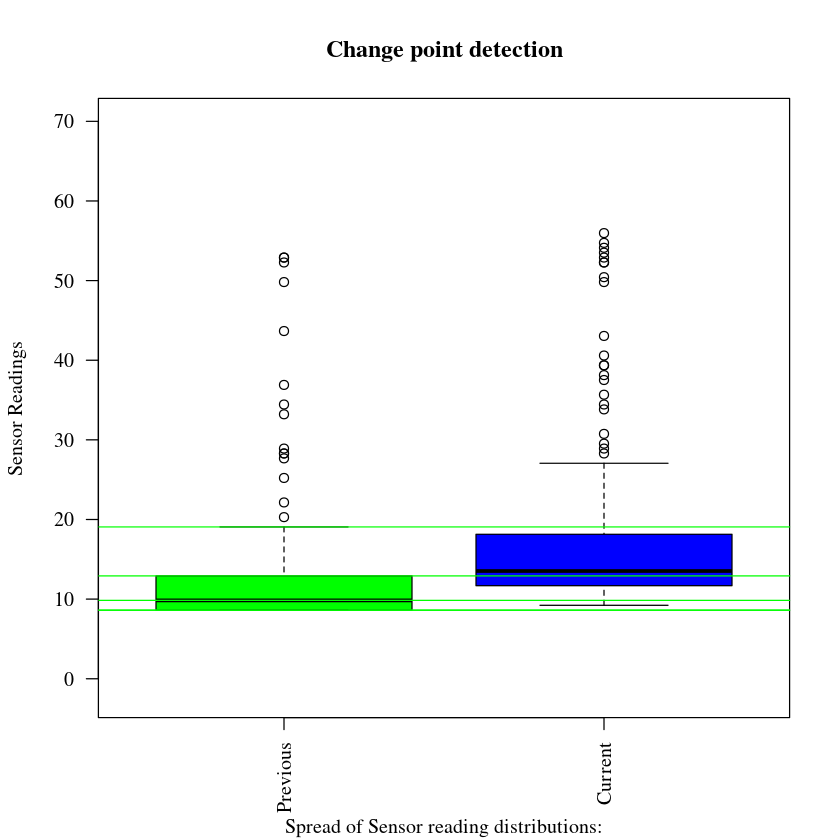

In [20]:
# Plot the 2 box plots for the distribution
f_plot2boxes(s1sensorvalue = series1$SensorValue,
             s2sensorvalue = series2$SensorValue)


# 6 Statistical Change point detection

## 6.1 Calculate the stats for both the series <br/>

In [21]:
# Function to calculate the stats for both the series <br/>
# Avg, Median, p1sd, p2sd, p3sd, n1sd, n2sd, n3sd, q0, q1, q2, q3, q4, f1range, <br/>
#      iqrange, f2range, sku, kurt, outliers

f_seriesstats <- function(series)
{
  boxstats <- boxplot.stats(series, coef=1.57, do.conf = TRUE, do.out = TRUE)
  smin <- min(series)
  smax <- max(series)
  smean <- mean(series)
  #Spread measures
  sq0 <- boxstats$stats[1]
  sq1 <- boxstats$stats[2]
  sq2 <- boxstats$stats[3]
  sq3 <- boxstats$stats[4]
  sq4 <- boxstats$stats[5]
  siqr <- (sq3 - sq1)
  # Normal distribution
  s1sd <- sd(series)
  s1sdp <- smean + s1sd
  s1sdn <- smean - s1sd
  s2sdp <- smean + (2*s1sd)
  s2sdn <- smean - (2*s1sd)
  s3sdp <- smean + (3*s1sd)
  s3sdn <- smean - (3*s1sd)
  # Outlier counts @ 2sd
  s2sdout <- sum(series > s2sdp) + sum(series < s2sdn)
  # return(list(smin, smax, smean, sq0, sq1, sq2, sq3, sq4, siqr, s1sd, s1sdp,
                                        # s1sdn, s2sdp, s2sdn, s3sdp, s3sdn))
  return(list(smin=smin, smax=smax, smean=smean,
              sq0=sq0, sq1=sq1, sq2=sq2, sq3=sq3, sq4=sq4, siqr=siqr,
              s1sd=s1sd, s1sdp=s1sdp, s1sdn=s1sdn,
              s2sdp=s2sdp, s2sdn=s2sdn, s3sdp=s3sdp, s3sdn=s3sdn))
}


In [22]:
# Compute the statistics for both series and check results
s1stats <- f_seriesstats(series1$SensorValue)
s2stats <- f_seriesstats(series2$SensorValue)


## 6.2 Calculate change point deviations

In [23]:
## Function to calculate change point deviatrion percentages
f_changepercent <- function(val1, val2)
{
  return(((val2-val1)/val1)*100)
}

# Calculate percentage deviation for individual stats
f_serieschangepercent <- function(series1stats, series2stats)
{
  n <- length(series1stats)
  cols=names(series2stats)
  cpdf <- data.frame(statname=character(), series1val = numeric(), 
                     series2val=numeric(), changeper=numeric());
  for (i in 1:length(series2stats))
  {
    newrow = data.frame(statname=cols[i], 
                        series1val=series1stats[[i]], 
                        series2val=series2stats[[i]], 
                        changeper=f_changepercent(series1stats[[i]], series2stats[[i]]))
    cpdf <- rbind(cpdf, newrow)
  }
  return(cpdf)
}

# Calculate overall percentage deviation and detect change point
f_detectchangepoint <- function(dfcp, threshold)
{
  # Overall percentage deviation
  newrow = data.frame(statname='overall',
                      series1val=NA,
                      series2val=NA,
                      changeper=mean(abs(dfcp$changeper)))
  dfcp <- rbind(dfcp, newrow)
  # Overall change point percentage
  changepointper <- dfcp[which(dfcp$statname=="overall"),c("changeper")]
  # Mark change point at threshold %
  if(changepointper > threshold)
    {return(paste("Change Point DETECTED exceeding threshold: ",threshold,"% ", sep=""))}
  else
    {return(paste("Change Point NOT DETECTED at threshold: ",threshold,"% ", sep=""))}
}


### Overall change percentage and individual key statistics


In [24]:
# Overall change percentage in key statistics
dfallstats <- f_serieschangepercent(s1stats, s2stats)
print(dfallstats)
# Detect changepoint
f_detectchangepoint(dfallstats, v_thresholdpercent)


   statname series1val series2val changeper
1      smin   8.610000   9.225000  7.142857
2      smax  52.890000  55.965000  5.813953
3     smean  13.073021  18.168125 38.974191
4       sq0   8.610000   9.225000  7.142857
5       sq1   8.610000  11.685000 35.714286
6       sq2   9.840000  13.530000 37.500000
7       sq3  12.915000  18.142500 40.476190
8       sq4  19.065000  27.060000 41.935484
9      siqr   4.305000   6.457500 50.000000
10     s1sd   8.861824  11.444024 29.138478
11    s1sdp  21.934845  29.612149 35.000497
12    s1sdn   4.211197   6.724101 59.671956
13    s2sdp  30.796669  41.056174 33.313685
14    s2sdn  -4.650627  -4.719924  1.490057
15    s3sdp  39.658493  52.500198 32.380721
16    s3sdn -13.512451 -16.163948 19.622625


[1] "Change Point DETECTED exceeding threshold: 25% "